# Feature Engineering

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
import pandas as pd

user_logs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Final/user_log.csv')
user_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Final/user_info.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Final/train.csv')

In [120]:
user_logs = user_logs.rename(columns={'seller_id': 'merchant_id'})
# Merge Data Frames
df = user_logs.merge(user_info, on='user_id')

In [121]:
user_logs.head()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,219316,472,737,801,5890.0,1018,0
1,69247,471,1266,4614,4331.0,619,2
2,69247,471,1266,4614,4331.0,619,0
3,216952,352,991,3527,869.0,626,0
4,216952,352,991,3527,869.0,626,0


## User Behavior Features

In [122]:
# Number of unique categories the user has interacted with
unique_categories = user_logs.groupby('user_id')['cat_id'].nunique()

# Number of unique merchants the user has interacted with
unique_merchants = user_logs.groupby('user_id')['merchant_id'].nunique()

# Number of unique brands the user has interacted with
unique_brands = user_logs.groupby('user_id')['brand_id'].nunique()

# Click-to-purchase ratio for each user
clicks = user_logs[user_logs['action_type'] == 0].groupby('user_id').size()
purchases = user_logs[user_logs['action_type'] == 2].groupby('user_id').size()
click_to_purchase_ratio = purchases / clicks

# Combine the results into the user_summary DataFrame
user_summary = pd.concat([unique_categories, unique_merchants, unique_brands, click_to_purchase_ratio], axis=1)

user_summary.columns = ['unique_categories', 'unique_merchants', 'unique_brands', 'click_to_purchase_ratio']

# Reset the index and fill NaN values with 0
user_summary.reset_index(inplace=True)
user_summary.fillna(0, inplace=True)

In [123]:
user_summary.head(500)

,user_id,unique_categories,unique_merchants,unique_brands,click_to_purchase_ratio
0,313,1,1,1,0.000000
1,502,1,1,1,0.000000
2,521,1,1,1,0.000000
3,648,1,1,1,0.000000
4,740,1,1,1,0.000000
...,...,...,...,...,...
495,53998,1,1,1,0.000000
496,54272,1,1,1,0.000000
497,54559,1,1,1,0.000000
498,54779,1,1,1,0.000000


In [124]:
print(user_summary.shape)

(3929, 5)


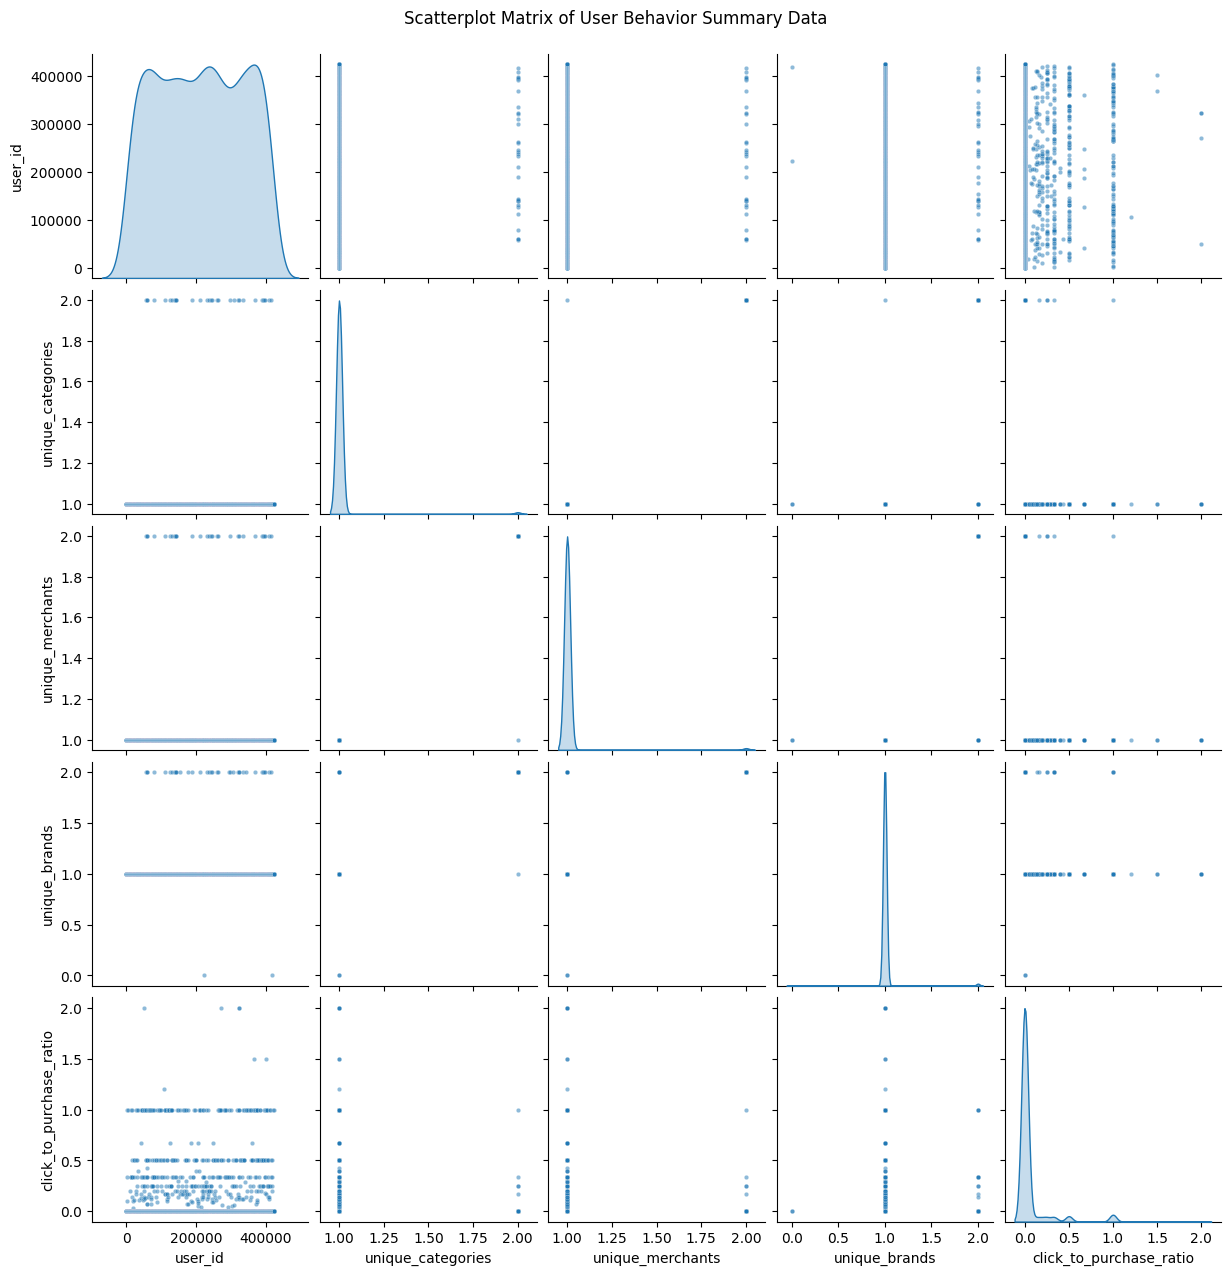

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot matrix
g = sns.pairplot(user_summary, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})
g.fig.suptitle('Scatterplot Matrix of User Behavior Summary Data', y=1.02)

g.savefig('scatterplot_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

## Merchant-Related Features

In [126]:
# Number of unique users that have interacted with the merchant
unique_users = user_logs.groupby('merchant_id')['user_id'].nunique()

# Merchant's overall click-to-purchase ratio
merchant_purchases = user_logs[user_logs['action_type'] == 2].groupby('merchant_id').size()

# Merchant's overall add-to-cart-to-purchase ratio
merchant_add_to_cart = user_logs[user_logs['action_type'] == 1].groupby('merchant_id').size()
merchant_add_to_cart_to_purchase_ratio = merchant_purchases / merchant_add_to_cart

# Merchant's overall add-to-favorite-to-purchase ratio
merchant_add_to_favorites = user_logs[user_logs['action_type'] == 3].groupby('merchant_id').size()
merchant_add_to_favorites_to_purchase_ratio = merchant_purchases / merchant_add_to_favorites

# Combine the results into a new DataFrame
merchant_summary = pd.DataFrame({'unique_users': unique_users, 
                                 'add_to_cart_to_purchase_ratio': merchant_add_to_cart_to_purchase_ratio,
                                 'add_to_favorites_to_purchase_ratio': merchant_add_to_favorites_to_purchase_ratio}).fillna(0)

# Reset the index
merchant_summary.reset_index(inplace=True)

In [127]:
merchant_summary.head(100)

,merchant_id,unique_users,add_to_cart_to_purchase_ratio,add_to_favorites_to_purchase_ratio
0,20,3,0.0,0.00
1,28,10,0.0,0.00
2,59,1,0.0,0.00
3,99,1,0.0,0.00
4,121,9,0.0,0.00
...,...,...,...,...
95,3202,5,0.0,0.00
96,3324,5,0.0,0.00
97,3334,11,0.0,0.00
98,3432,254,0.0,1.08


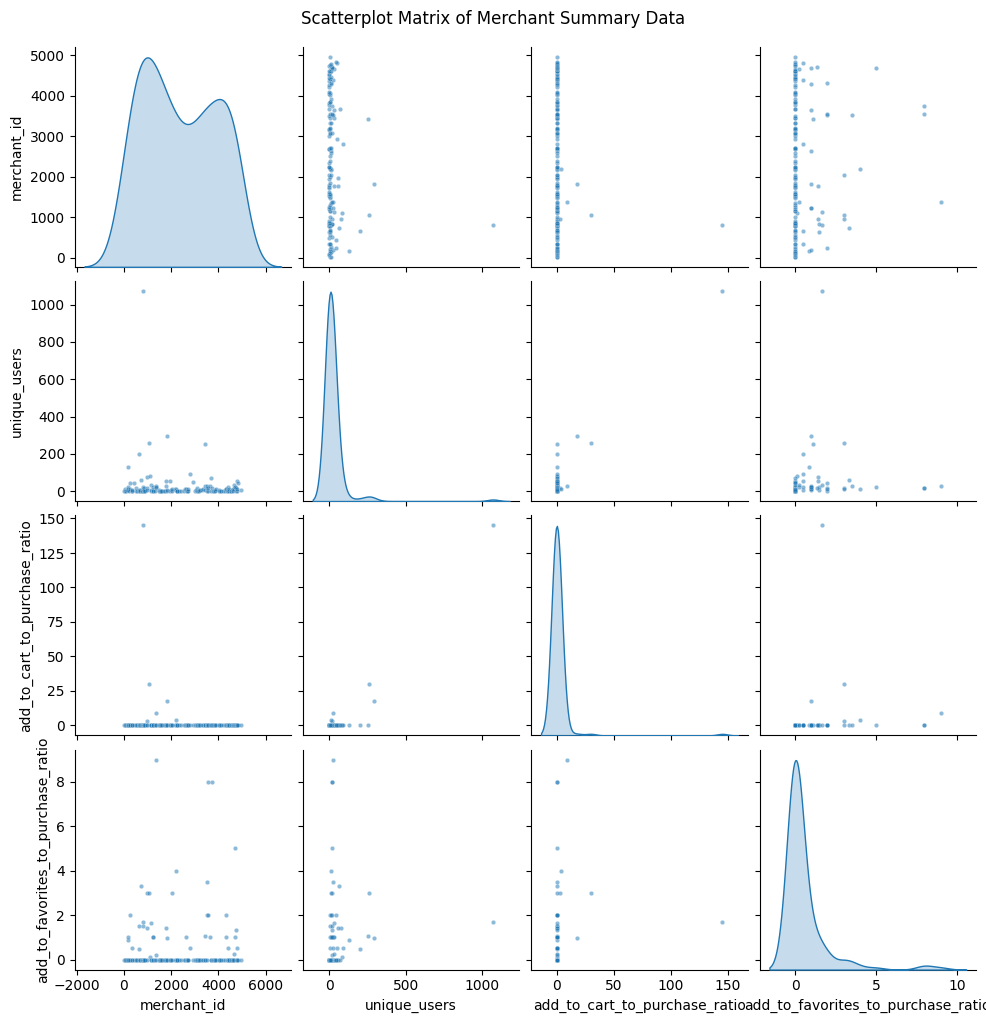

In [128]:
g = sns.pairplot(merchant_summary, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})
g.fig.suptitle('Scatterplot Matrix of Merchant Summary Data', y=1.02)

g.savefig('scatterplot_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

## Interaction Features

In [129]:
# Convert time_stamp to day of the year
user_logs['day_of_year'] = user_logs['time_stamp'].apply(lambda x: pd.to_datetime(x, format='%m%d').timetuple().tm_yday)

# Number of interactions between each user and merchant
interaction_count = user_logs.groupby(['user_id', 'merchant_id']).size().reset_index(name='interaction_count')

# Time since the last interaction between each user and merchant
last_interaction = user_logs.groupby(['user_id', 'merchant_id'])['day_of_year'].max().reset_index(name='last_interaction')

# Time since the first interaction between each user and merchant
first_interaction = user_logs.groupby(['user_id', 'merchant_id'])['day_of_year'].min().reset_index(name='first_interaction')

# Average time between interactions for each user and merchant
average_time_between_interactions = user_logs.groupby(['user_id', 'merchant_id'])['day_of_year'].apply(lambda x: x.sort_values().diff().mean()).fillna(0).reset_index(name='average_time_between_interactions')

# Number of interactions in each action type between each user and merchant
action_counts = user_logs.groupby(['user_id', 'merchant_id', 'action_type']).size().unstack(fill_value=0).reset_index().rename(columns={0: 'clicks', 1: 'add_to_cart', 2: 'purchases', 3: 'add_to_favorites'})

# Combine the results into a new DataFrame
interaction_summary = interaction_count.merge(last_interaction, on=['user_id', 'merchant_id'])
interaction_summary = interaction_summary.merge(first_interaction, on=['user_id', 'merchant_id'])
interaction_summary = interaction_summary.merge(average_time_between_interactions, on=['user_id', 'merchant_id'])
interaction_summary = interaction_summary.merge(action_counts, on=['user_id', 'merchant_id'])

# Calculate time since the last and first interaction (in days)
interaction_summary['days_since_last_interaction'] = interaction_summary['last_interaction'].max() - interaction_summary['last_interaction']
interaction_summary['days_since_first_interaction'] = interaction_summary['last_interaction'].max() - interaction_summary['first_interaction']

# Drop unnecessary columns
interaction_summary.drop(['last_interaction', 'first_interaction'], axis=1, inplace=True)

In [130]:
interaction_summary.head(100)

,user_id,merchant_id,interaction_count,average_time_between_interactions,clicks,add_to_cart,purchases,add_to_favorites,days_since_last_interaction,days_since_first_interaction
0,313,442,2,0.000000,2,0,0,0,172,172
1,502,1963,1,0.000000,1,0,0,0,4,4
2,521,801,2,0.000000,2,0,0,0,26,26
3,648,801,1,0.000000,1,0,0,0,49,49
4,740,1102,4,8.666667,3,0,0,1,113,139
...,...,...,...,...,...,...,...,...,...,...
95,11572,3432,2,0.000000,2,0,0,0,1,1
96,11791,651,2,2.000000,2,0,0,0,0,2
97,11852,1713,1,0.000000,1,0,0,0,173,173
98,11952,651,7,0.833333,7,0,0,0,0,5


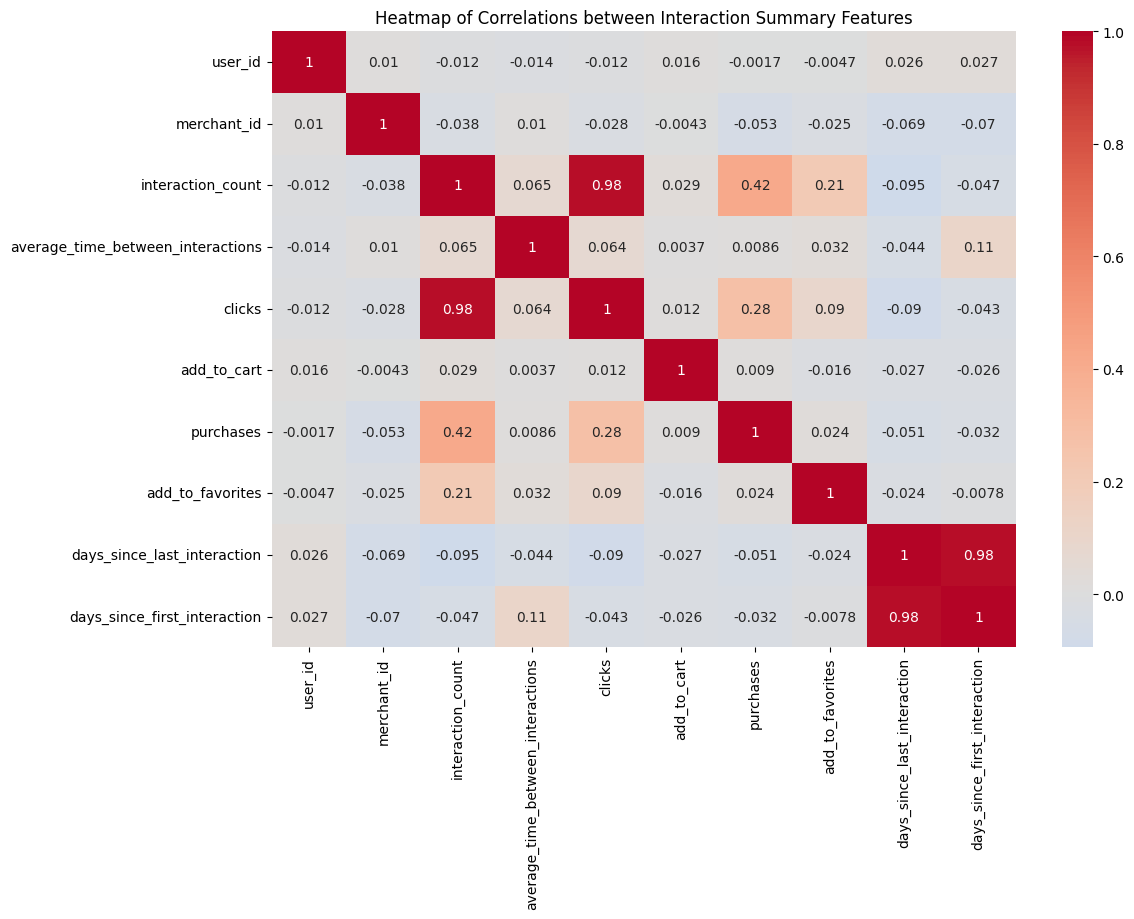

In [131]:
# Calculate the correlation matrix
interaction_summary_corr = interaction_summary.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_summary_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlations between Interaction Summary Features')
plt.show()

## Demographic Features

In [132]:
# Create a dictionary to map age_range to its corresponding age group
age_range_map = {1: '<18', 2: '18-24', 3: '25-29', 4: '30-34', 5: '35-39', 6: '40-49', 7: '>50', 8: '>50', 0: 'unknown'}

# Create a dictionary to map gender to its corresponding gender group
gender_map = {0: 'Female', 1: 'Male', 2: 'Unknown'}

# Combine age_range and gender into a new categorical feature
user_info['demographic_group'] = user_info['age_range'].map(age_range_map) + '_' + user_info['gender'].map(gender_map)

# Merge user_info with user_logs
user_logs_demographic = user_logs.merge(user_info[['user_id', 'age_range', 'gender']], on='user_id')

# Calculate the number of interactions for each demographic group per merchant
demographic_interactions = user_logs_demographic.groupby('user_id').size().reset_index(name='age_range_to_gender_interaction_count')

In [133]:
demographic_interactions.head(100)

,user_id,age_range_to_gender_interaction_count
0,313,2
1,502,1
2,521,2
3,648,1
4,740,4
...,...,...
95,11572,2
96,11791,2
97,11852,1
98,11952,7


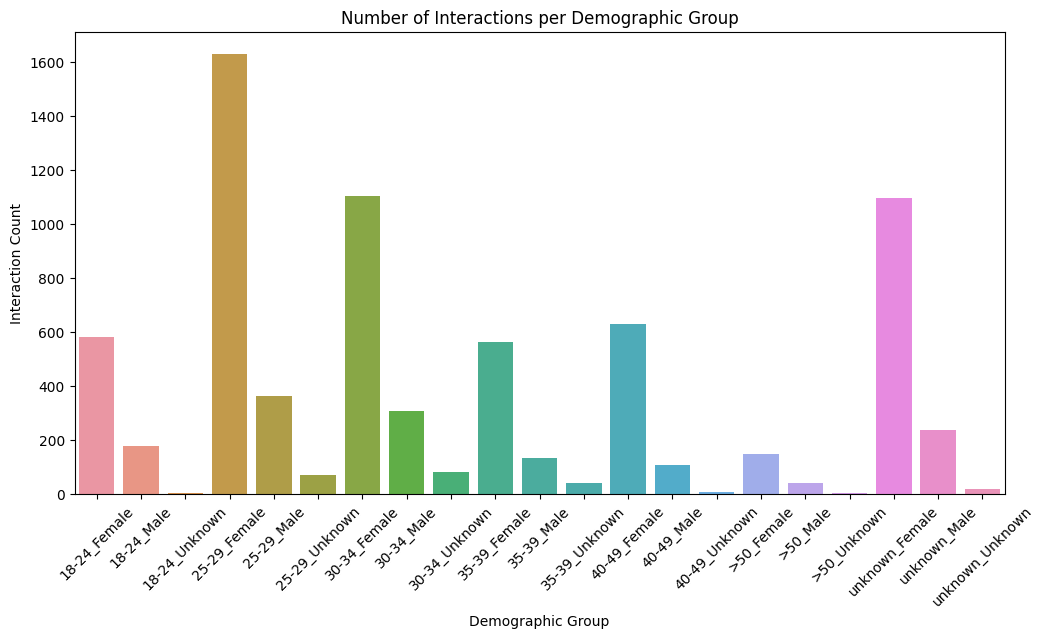

In [134]:
# Create a dictionary to map age_range to its corresponding age group
age_range_map = {1: '<18', 2: '18-24', 3: '25-29', 4: '30-34', 5: '35-39', 6: '40-49', 7: '>50', 8: '>50', 0: 'unknown'}

# Create a dictionary to map gender to its corresponding gender group
gender_map = {0: 'Female', 1: 'Male', 2: 'Unknown'}

# Combine age_range and gender into a new categorical feature
user_info['demographic_group'] = user_info['age_range'].map(age_range_map) + '_' + user_info['gender'].map(gender_map)

# Merge user_info with user_logs
user_logs_demographic = user_logs.merge(user_info[['user_id', 'age_range', 'gender', 'demographic_group']], on='user_id')

# Calculate the number of interactions for each demographic group per merchant
demographic_interactions_1 = user_logs_demographic.groupby('demographic_group').size().reset_index(name='interaction_count')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=demographic_interactions_1, x='demographic_group', y='interaction_count')
plt.title('Number of Interactions per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Interaction Count')
plt.xticks(rotation=45)
plt.show()

## Temporal Features

In [135]:
import datetime

def extract_day_of_week(time_stamp):
    time_stamp_str = str(time_stamp).zfill(4)
    month, day = int(time_stamp_str[:2]), int(time_stamp_str[2:])
    return datetime.datetime(year=1900, month=month, day=day).weekday()

def extract_month(time_stamp):
    time_stamp_str = str(time_stamp).zfill(4)
    return int(time_stamp_str[:2])

user_logs['day_of_week'] = user_logs['time_stamp'].apply(extract_day_of_week)
user_logs['month'] = user_logs['time_stamp'].apply(extract_month)

# Calculate the number of interactions (click, add-to-cart, purchase, add-to-favorite) by each user per day of the week and month.
user_interactions_day_of_week = user_logs.groupby(['user_id', 'day_of_week', 'action_type']).size().unstack(fill_value=0).reset_index()
user_interactions_month = user_logs.groupby(['user_id', 'month', 'action_type']).size().unstack(fill_value=0).reset_index()

In [136]:
user_interactions_day_of_week.head(100)

action_type,user_id,day_of_week,0,1,2,3
0,313,2,2,0,0,0
1,502,2,1,0,0,0
2,521,1,2,0,0,0
3,648,6,1,0,0,0
4,740,0,1,0,0,0
...,...,...,...,...,...,...
95,10094,1,1,0,0,0
96,10160,1,2,0,0,1
97,10160,2,1,0,0,0
98,10234,6,1,0,0,0


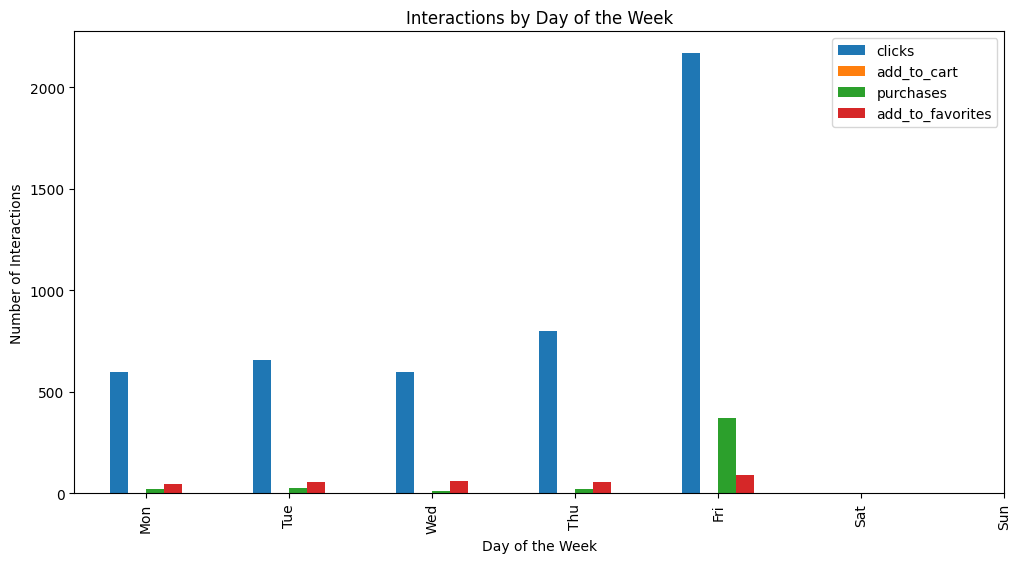

In [137]:
import datetime

def extract_day_of_week(time_stamp):
    time_stamp_str = str(time_stamp).zfill(4)
    month, day = int(time_stamp_str[:2]), int(time_stamp_str[2:])
    return datetime.datetime(year=1900, month=month, day=day).weekday()

user_logs['day_of_week'] = user_logs['time_stamp'].apply(extract_day_of_week)

# Calculate the counts for each action type separately
clicks_day_of_week = user_logs[user_logs['action_type'] == 0].groupby(['day_of_week']).size().reset_index(name='clicks')
add_to_cart_day_of_week = user_logs[user_logs['action_type'] == 1].groupby(['day_of_week']).size().reset_index(name='add_to_cart')
purchases_day_of_week = user_logs[user_logs['action_type'] == 2].groupby(['day_of_week']).size().reset_index(name='purchases')
add_to_favorites_day_of_week = user_logs[user_logs['action_type'] == 3].groupby(['day_of_week']).size().reset_index(name='add_to_favorites')

# Combine the results into the final DataFrame
day_of_week_summary = clicks_day_of_week.merge(add_to_cart_day_of_week, on='day_of_week')
day_of_week_summary = day_of_week_summary.merge(purchases_day_of_week, on='day_of_week')
day_of_week_summary = day_of_week_summary.merge(add_to_favorites_day_of_week, on='day_of_week')

# Create a bar plot for interactions by day of the week
day_of_week_summary.plot(x='day_of_week', y=['clicks', 'add_to_cart', 'purchases', 'add_to_favorites'], kind='bar', figsize=(12, 6))
plt.title('Interactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Interactions')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [138]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Final/train.csv')
user_logs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/Final/user_log.csv')
user_logs = user_logs.rename(columns={'seller_id': 'merchant_id'})

logs = pd.merge(user_logs, train, on=['user_id', 'merchant_id'])

print("Values:")
print(logs['label'].value_counts())

Values:
0    324
1     66
Name: label, dtype: int64


In [139]:
user_logs_demographic.head()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type,day_of_year,age_range,gender,demographic_group
0,219316,472,737,801,5890.0,1018,0,291,4.0,0.0,30-34_Female
1,69247,471,1266,4614,4331.0,619,2,170,4.0,1.0,30-34_Male
2,69247,471,1266,4614,4331.0,619,0,170,4.0,1.0,30-34_Male
3,216952,352,991,3527,869.0,626,0,177,5.0,2.0,35-39_Unknown
4,216952,352,991,3527,869.0,626,0,177,5.0,2.0,35-39_Unknown


In [140]:
logs = logs.merge(user_summary, on='user_id', how='left')
logs = logs.merge(user_info, on='user_id', how='left')
logs = logs.merge(merchant_summary, on='merchant_id', how='left')
logs = logs.merge(interaction_summary, on=['user_id', 'merchant_id'], how='left')
logs = logs.merge(user_interactions_day_of_week, on='user_id', how='left')
logs = logs.merge(demographic_interactions, on='user_id', how='left')
logs = logs.drop('demographic_group', axis=1)

In [141]:
# User's lifetime value (LTV): This is the total revenue generated by a user since their first purchase. It can help identify high-value customers who are more likely to make repeat purchases.
logs['ltv'] = logs.groupby('user_id')['purchases'].transform('sum')

In [142]:
# Frequency of previous purchases: The number of times a user has made a purchase before the current promotional event. Customers with a higher frequency of past purchases are more likely to be loyal customers.
logs['previous_purchase_count'] = logs.groupby('user_id')['purchases'].transform('count')

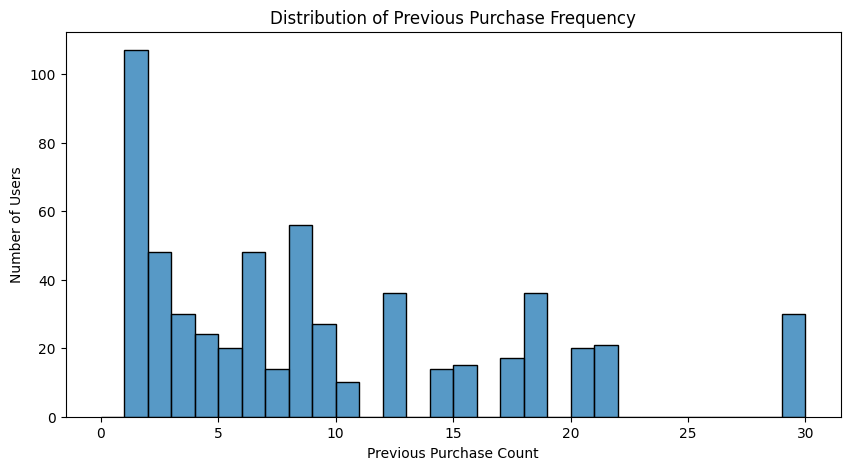

In [143]:
import numpy as np

plt.figure(figsize=(10, 5))
sns.histplot(logs['previous_purchase_count'], bins=np.arange(0, logs['previous_purchase_count'].max() + 1), kde=False)
plt.title('Distribution of Previous Purchase Frequency')
plt.xlabel('Previous Purchase Count')
plt.ylabel('Number of Users')
plt.show()

In [144]:
# Time since last purchase: The time elapsed since a user's most recent purchase. Users who have made a purchase more recently might be more likely to make another purchase.
logs['time_since_last_purchase'] = logs.groupby('user_id')['time_stamp'].transform(lambda x: x.max() - x.min())


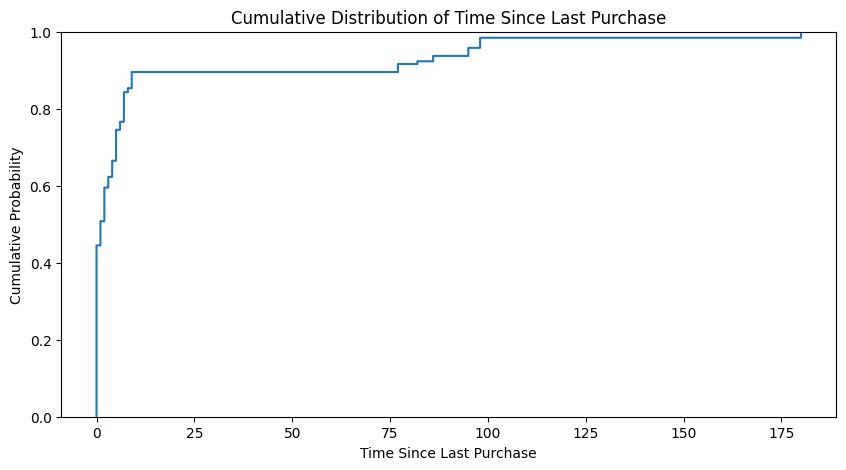

In [145]:
plt.figure(figsize=(10, 5))
sns.ecdfplot(logs['time_since_last_purchase'])
plt.title('Cumulative Distribution of Time Since Last Purchase')
plt.xlabel('Time Since Last Purchase')
plt.ylabel('Cumulative Probability')
plt.show()

In [146]:
# User's average order value: The average value of a user's past orders. Users who tend to spend more per order might be more valuable to target.
logs['average_order_value'] = logs.groupby('user_id')['purchases'].transform('mean')

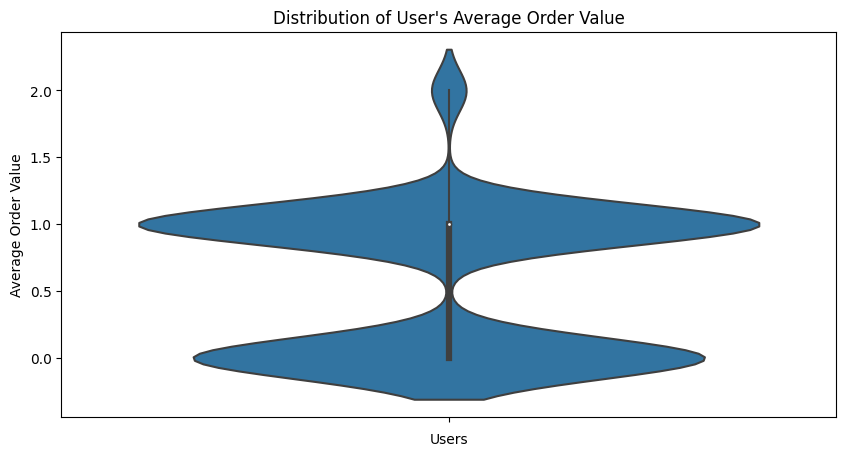

In [147]:
plt.figure(figsize=(10, 5))
sns.violinplot(y='average_order_value', data=logs)
plt.title("Distribution of User's Average Order Value")
plt.xlabel('Users')
plt.ylabel('Average Order Value')
plt.show()

In [148]:
# User's average days between purchases: This can help identify users with a consistent purchasing pattern, who are more likely to make another purchase within the next 6 months.
logs['average_days_between_purchases'] = logs.groupby('user_id')['time_stamp'].transform(lambda x: x.diff().mean())

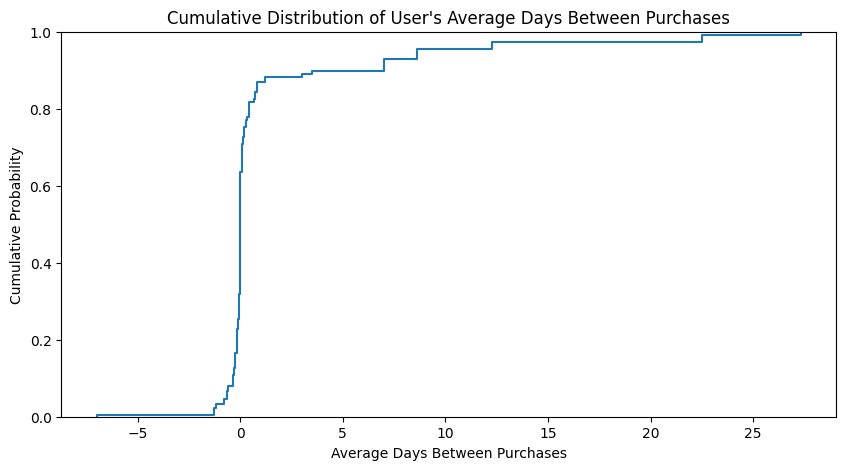

In [149]:
plt.figure(figsize=(10, 5))
sns.ecdfplot(logs['average_days_between_purchases'].dropna())
plt.title("Cumulative Distribution of User's Average Days Between Purchases")
plt.xlabel('Average Days Between Purchases')
plt.ylabel('Cumulative Probability')
plt.show()

In [150]:
# User's promotional engagement: The number of promotional events a user has participated in or the number of promotions redeemed by the user. Users who engage more with promotions might be more likely to make repeat purchases.
logs['promo_engagement'] = logs.groupby('user_id')['action_type'].transform(lambda x: (x == 2).sum())

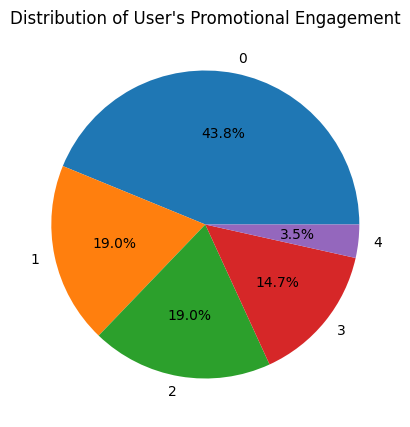

In [151]:
promo_engagement_counts = logs['promo_engagement'].value_counts()
plt.figure(figsize=(10, 5))
plt.pie(promo_engagement_counts, labels=promo_engagement_counts.index, autopct='%1.1f%%')
plt.title("Distribution of User's Promotional Engagement")
plt.show()

In [152]:
# Category or product affinity: The user's preference for certain product categories or specific items. This can help tailor the promotional offers to individual user preferences, increasing the likelihood of repeat purchases.
logs['cat_affinity'] = logs.groupby(['user_id', 'cat_id'])['purchases'].transform('sum')

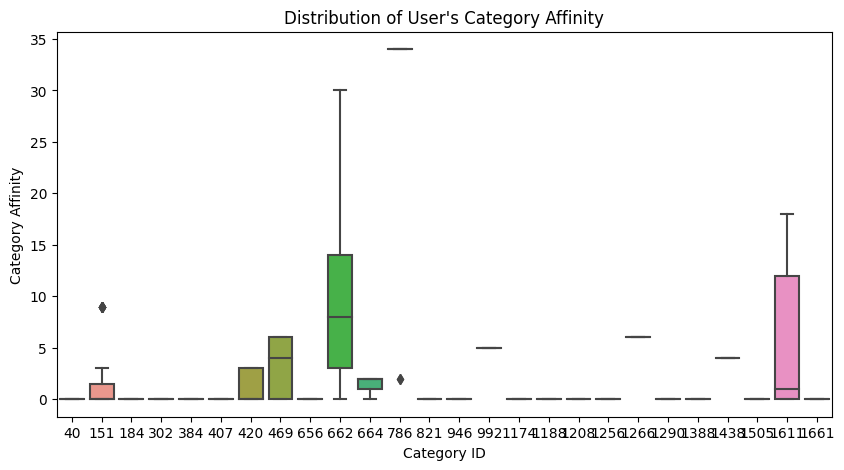

In [153]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cat_id', y='cat_affinity', data=logs)
plt.title("Distribution of User's Category Affinity")
plt.xlabel('Category ID')
plt.ylabel('Category Affinity')
plt.show()

In [154]:
# User's browsing behavior: The number of pages viewed, time spent on the platform, or the bounce rate of a user. Users with more active browsing behavior might be more engaged and more likely to make repeat purchases.
logs['pages_viewed'] = logs.groupby('user_id')['clicks'].transform('sum')

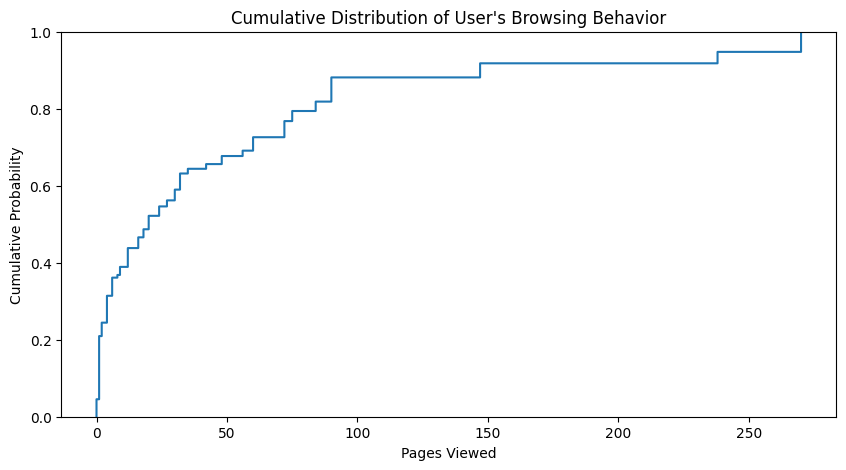

In [155]:
plt.figure(figsize=(10, 5))
sns.ecdfplot(logs['pages_viewed'])
plt.title("Cumulative Distribution of User's Browsing Behavior")
plt.xlabel('Pages Viewed')
plt.ylabel('Cumulative Probability')
plt.show()

In [156]:
logs = logs.drop_duplicates()
logs = logs.fillna(0)

In [157]:
logs.head()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type,label,unique_categories,unique_merchants,...,3,age_range_to_gender_interaction_count,ltv,previous_purchase_count,time_since_last_purchase,average_order_value,average_days_between_purchases,promo_engagement,cat_affinity,pages_viewed
0,190023,424,662,3432,5093.0,1111,0,0,1,1,...,1,6,6,6,0,1.0,0.0,1,6,24
3,190023,424,662,3432,5093.0,1111,3,0,1,1,...,1,6,6,6,0,1.0,0.0,1,6,24
4,190023,424,662,3432,5093.0,1111,2,0,1,1,...,1,6,6,6,0,1.0,0.0,1,6,24
6,59812,391,1438,4687,277.0,1111,0,0,1,1,...,0,4,4,4,0,1.0,0.0,1,4,12
8,59812,391,1438,4687,277.0,1111,2,0,1,1,...,0,4,4,4,0,1.0,0.0,1,4,12


In [158]:
logs.to_csv('updated_train.csv', index=True)